# Velocity field and dispersion comparison between HC$_3$N and NH$_3$

In [1]:
import numpy as np
from astropy.io import fits
from reproject import reproject_exact
%matplotlib inline
import matplotlib.pyplot as plt
import aplpy
from B5setup import *
from scipy import stats
from scipy.integrate import simpson
import os

We first create an NH$_3$ map which shares the same grid as the actual HC$_3$N image we produced with the Gaussian fit. Here we can choose to work with the velocity field or dispersion

In [2]:
folderHC3N = 'gaussfit/'
folderNH3 = '../B5_wide_multiple/data/'
# For Velocity field uncomment:
HC3Ndatafile = 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr'
NH3datafile = 'B5_VLA_GBT_model_vc_QA'
diffdatafile = 'B5_Vlsr_HC3N_minus_NH3'

# For Velocity dispersion uncomment:
# HC3Ndatafile = 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_SigmaV'
# NH3datafile = 'B5_VLA_GBT_model_dv_QA'
# diffdatafile = 'B5_SigmaV_HC3N_minus_NH3'

In [3]:
if not os.path.exists(folderHC3N + NH3datafile + '_reprojectHC3N.fits'):
    NH3hdu = fits.open(folderNH3 + NH3datafile + '.fits')
    key_remove = ['PC03_01', 'PC04_01', 'PC01_03', 'PC02_03', 'PC03_02', 'PC04_02','PC03_03', 'PC04_03', 'PC01_04',
                  'PC02_04', 'PC03_04', 'PC04_04', 'CUNIT3', 'CRPIX4','CDELT4','CUNIT4','CTYPE4','CRVAL4','SPECSYS']
    for key_i in key_remove: # there are more dimensions written in the NH3 fits file
        NH3hdu[0].header.remove(key_i)
    HC3Nheader = fits.getheader(folderHC3N + HC3Ndatafile + '.fits')
    newNH3image, footprint = reproject_exact(NH3hdu[0], HC3Nheader)
    # now we modify the spatial properties of the NH3 Header
    newheader = NH3hdu[0].header.copy() # we use this header as it has the resolution
    key_modify = ['CUNIT1', 'CRPIX1','CDELT1','CTYPE1','CRVAL1', 'CUNIT2', 'CRPIX2','CDELT2','CTYPE2','CRVAL2']
    for key_i in key_modify: # there are more dimensions written in the NH3 fits file
        newheader[key_i] = HC3Nheader[key_i]

    fits.writeto(folderHC3N + NH3datafile + '_reprojectHC3N.fits', newNH3image, newheader)
    NH3hdu.close()
else:
    newNH3image = fits.getdata(folderHC3N + NH3datafile + '_reprojectHC3N.fits')

Now that we did the reprojection, we use the data only.

We first look at the difference of HC$_3$N with respect to NH$_3$

In [4]:
HC3Ndata = fits.getdata(folderHC3N + HC3Ndatafile + '.fits')
HC3Nheader = fits.getheader(folderHC3N + HC3Ndatafile + '.fits')
diff = HC3Ndata - newNH3image
newhead = HC3Nheader.copy()
newhead.remove('BUNIT')
if not os.path.exists(folderHC3N + diffdatafile + '.fits'):
    fits.writeto(folderHC3N + diffdatafile + '.fits', diff, newhead)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


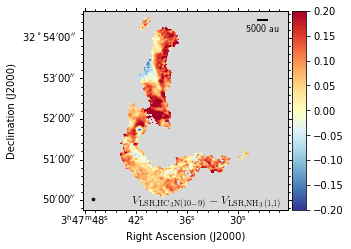

In [5]:
# we plot quickly the difference
fig = plt.figure(figsize=(4,4))
velmin = -0.2
velmax = 0.2
ax = plot_aplpy_subfig(folderHC3N + diffdatafile + '.fits', 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')
ax.add_label(0.6, 0.04, 
             r'$V_{\mathrm{LSR},\mathrm{HC}_3\mathrm{N}(10-9)} - V_{\mathrm{LSR}, \mathrm{NH}_3(1,1)}$', 
             relative=True, family='sans-serif', size=12)
fig.savefig(folderHC3N + diffdatafile + '.pdf', bbox_inches='tight')

Now we do the KDE of the velocity or dispersion distribution

In [6]:
# create the grid for the 1D kernel distribution
data_kde = np.linspace(-0.4, 0.4, 100)
data = fits.getdata(folderHC3N + diffdatafile + '.fits').flatten()
data = data[~np.isnan(data)]
p_range = np.array([0.15865 * 100, 50., 0.84135 * 100]) # I believe this is one sigma? ask Jaime
vlsr_median_unc = np.round(np.percentile(data, p_range), decimals=2)

kernel = stats.gaussian_kde(data)
dens = kernel(data_kde)
dens /= simpson(dens, data_kde) # normalizing of probability

datasave = np.array([data_kde, dens, vlsr_median_unc], dtype=object)
if not os.path.exists(folderHC3N + diffdatafile+'.npy'):
    np.save(folderHC3N + diffdatafile+'.npy', datasave)

Text(0.03, 1.1, '0.08$_{-0.06}^{+0.07}$')

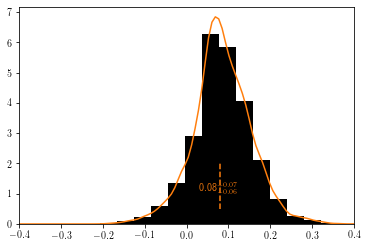

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data, fc='k', bins='sturges', density=True)
ax.plot(data_kde, dens)
ax.set_xlim([-0.4, 0.4])
ax.plot([vlsr_median_unc[1], vlsr_median_unc[1]], [0.5, 2], color='C1', ls='--')
ax.text(vlsr_median_unc[1]-0.05,1.1,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(vlsr_median_unc[1], vlsr_median_unc[0]-vlsr_median_unc[1], vlsr_median_unc[2]-vlsr_median_unc[1]), size=10, color='C1')


I'm not sure which is the best way to show the difference so we make a 2D KDE as well

In [8]:
# x is v_LSR of HC3N
xmin = 9.8
xmax = 10.8
# y is v_LSR of NH3
ymin = 9.8
ymax = 10.8
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
# we select only those who are not nan
gd_vlos = np.isfinite(HC3Ndata * newNH3image)
values = np.vstack([HC3Ndata[gd_vlos], newNH3image[gd_vlos]])
# we calculate the kernel distribution
kernel = stats.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)
zz /= zz.max()

datasave = np.array([xx, yy, zz])
if not os.path.exists(folderHC3N + diffdatafile+'_2DKDE.npy'):
    np.save(folderHC3N + diffdatafile+'_2DKDE.npy', datasave)


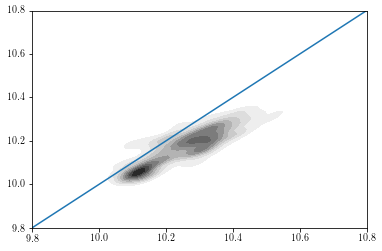

In [10]:
# just to check it quickly
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.plot([9.8, 10.8], [9.8, 10.8])